In [1]:
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

In [2]:
# Open CSV file containing data on CO2 Emission (in tons) by country between 1750 - 2017
emissions_df = pd.read_csv("co2_emission.csv", parse_dates=['Year'], dtype={'Annual CO₂ emissions (tonnes )':'float'})
emissions_df.rename(columns={'Annual CO₂ emissions (tonnes )': 'Annual Emissions'}, inplace=True)
emissions_df['Year'] = [y.year for y in emissions_df['Year']]
print(emissions_df.head(5))
countries_only = emissions_df[emissions_df['Entity'] != 'World']
maxx = countries_only['Annual Emissions'].max()
country = countries_only[['Entity', 'Year']].loc[countries_only['Annual Emissions'] == maxx]

        Entity Code  Year  Annual Emissions
0  Afghanistan  AFG  1949           14656.0
1  Afghanistan  AFG  1950           84272.0
2  Afghanistan  AFG  1951           91600.0
3  Afghanistan  AFG  1952           91600.0
4  Afghanistan  AFG  1953          106256.0


In [3]:
# Open Population Growth File
population_growth_df = pd.read_csv("world_population_growth.csv", dtype={'Year': 'int'})
population_growth_df.rename(columns={"World Population over 12000 years (various sources (2019))": "World Population"}, inplace=True)

# Drop unwanted columns
population_growth_df.drop(columns=['Entity', 'Code'], inplace=True)

# Create a copy of the co2 emissions dataframe that contains only Worldwide data
world_emissions = emissions_df[emissions_df['Entity'] == 'World'].copy()
world_emissions.reset_index(drop=True, inplace=True)

# Create a list containing all the years of worldwide eco2 emission data
years_to_find = [int(y) for y in world_emissions['Year']]

# Locate which of those years we have population data on
years_with_data = population_growth_df[population_growth_df['Year'].isin(years_to_find)]
years_with_data.reset_index(drop=True, inplace=True)

# Sort the data in chronological order
years_with_data = years_with_data.sort_values(by=['Year'])

# Since the dataset contained duplicate years (different sources), use the mean() of the reported populations for the given year.
years_grouped = years_with_data.groupby(['Year']).mean()

# Convert years with population data to  a list, then parse through the years from our co2 dataframe and if that year exists, 
# add the populations, to a new list, otherwise, add null and deal with later.
population_years = [y for y in years_grouped.index]
years_column = []
for years in world_emissions['Year']:
    if int(years) in population_years:
        pop = years_grouped.loc[years]
        years_column.append(pop.values[0])
    else:
        years_column.append(0)

#Create new dataframe column with population data
world_emissions['World Population'] = years_column
    

In [4]:
# Next we'll add a column for YoY % change for both the population and emissions columns
pct_change = world_emissions['Annual Emissions'].pct_change()
world_emissions['YoY Emissions Delta'] = pct_change
world_emissions['YoY Emissions Delta'] = world_emissions['YoY Emissions Delta'].fillna(0)
world_emissions['YoY Emissions Delta'] = [x*100 for x in world_emissions['YoY Emissions Delta']]

# Lets see if we can predict world population using the growth rate
co2_w_pop = world_emissions[world_emissions['World Population'] > 0].copy()

# Get % change for population in years that we have data
pct_change2 = co2_w_pop['World Population'].pct_change()
co2_w_pop['YoY Population Delta'] = pct_change2
co2_w_pop['YoY Population Delta'] = co2_w_pop['YoY Population Delta'].fillna(0)
avg_pct_change = co2_w_pop['YoY Population Delta'].loc[co2_w_pop['YoY Population Delta'] > 0].min()

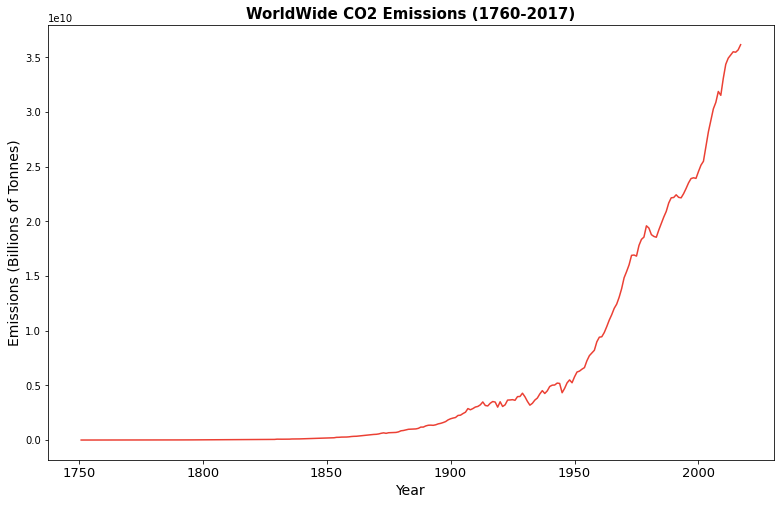

In [5]:
world_emissions.reset_index(drop=True, inplace=True)
plt.figure(figsize=(13,8))
plt.title('WorldWide CO2 Emissions (1760-2017)', fontdict={'fontsize':15, 'fontweight':'bold'})
plt.xlabel("Year", fontdict={'fontsize':14})
plt.ylabel("Emissions (Billions of Tonnes)", fontdict={'fontsize':14})
plt.xticks(fontsize=13)
plt.plot(world_emissions['Year'], world_emissions['Annual Emissions'], color='#eb4034')
plt.show()

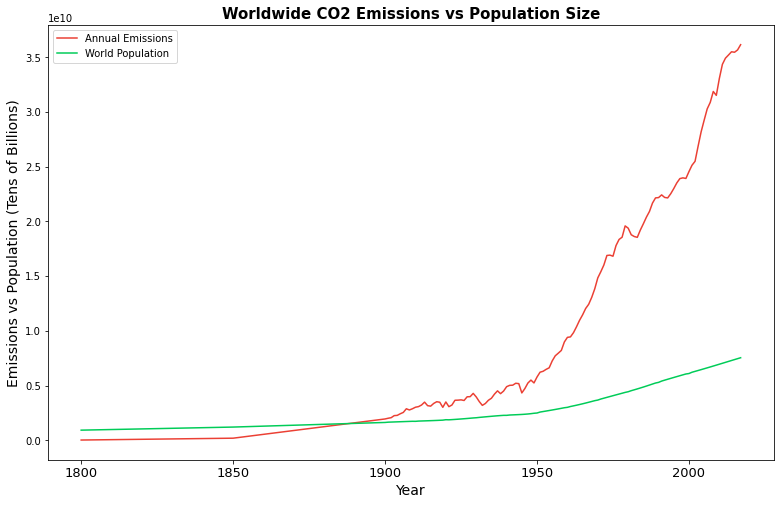

In [6]:

# Next we'll create a new DataFrame that contains only the years which have both Co2 Emission and Population data. 
co2_w_pop = world_emissions[world_emissions['World Population'] > 0]
plt.figure(figsize=(13,8))
plt.title('Worldwide CO2 Emissions vs Population Size', fontdict={'fontsize':15, 'fontweight':'bold'})
x_axis = co2_w_pop['Year']
plt.xlabel("Year", fontdict={'fontsize':14})
plt.ylabel("Emissions vs Population (Tens of Billions)", fontdict={'fontsize':14})
plt.xticks(fontsize=13)
plt.plot(x_axis, co2_w_pop['Annual Emissions'], color='#eb4034')
plt.plot(x_axis, co2_w_pop['World Population'], color='#00cc58')
plt.legend(['Annual Emissions', 'World Population'])
plt.show()

In [7]:
# Find year with greatest percent change in Annual Co2 emissions
greatest_pct_change = world_emissions['YoY Emissions Delta'].max()
year = world_emissions['Year'].loc[world_emissions['YoY Emissions Delta'] == greatest_pct_change]
greatest_year = year.values[0] # 1830
print("The year " + str(greatest_year) + " saw the greatest increase in CO2 Emissions with a " + str(round(greatest_pct_change, 2)) + "%" + " increase since the year prior.")

The year 1830 saw the greatest increase in CO2 Emissions with a 34.23% increase since the year prior.


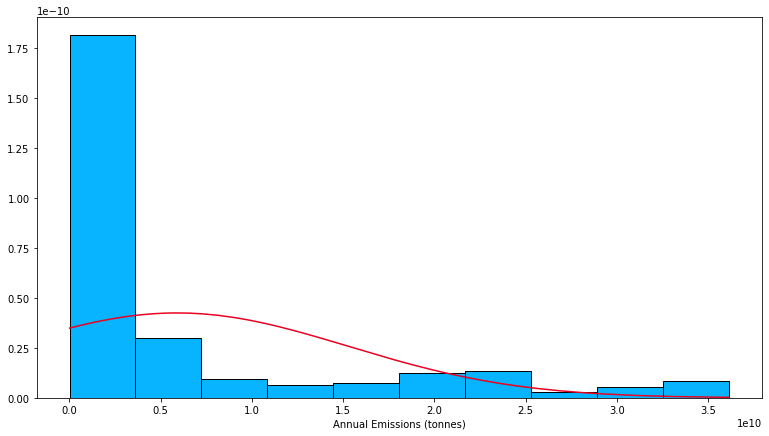

In [8]:
# Normal Distribution
plt.figure(figsize=(13,7))
grouped = emissions_df.groupby(['Entity']).sum()
grouped_year = emissions_df.groupby(['Year']).sum()
x_axis = sorted(world_emissions['Annual Emissions'].values)
# Create Histogram
plt.hist(world_emissions['Annual Emissions'], color='#08b4ff', edgecolor='black', density=True)
mean = world_emissions['Annual Emissions'].mean()
std = world_emissions['Annual Emissions'].std()
# Add labels and Title
plt.xlabel("Annual Emissions (tonnes)")
# Add line
plt.plot(x_axis, norm.pdf(x_axis, mean, std), color='#eb001f')
plt.show()

In [9]:
# Measure of United States annual CO2 emissions
usa = emissions_df[emissions_df['Entity'] == 'United States']
usa = usa[usa['Annual Emissions'] > 0]
usa = usa[usa['Year'] >= 1900]
# Measure of Chinese annual CO2 emissions
china = emissions_df[emissions_df['Entity'] == 'China']
china = china[china['Annual Emissions'] > 0]
# Find year with Maximum Co2 emissions
max_co2 = usa['Annual Emissions'].max()
year_of_max = usa['Year'].loc[usa['Annual Emissions'] == max_co2]

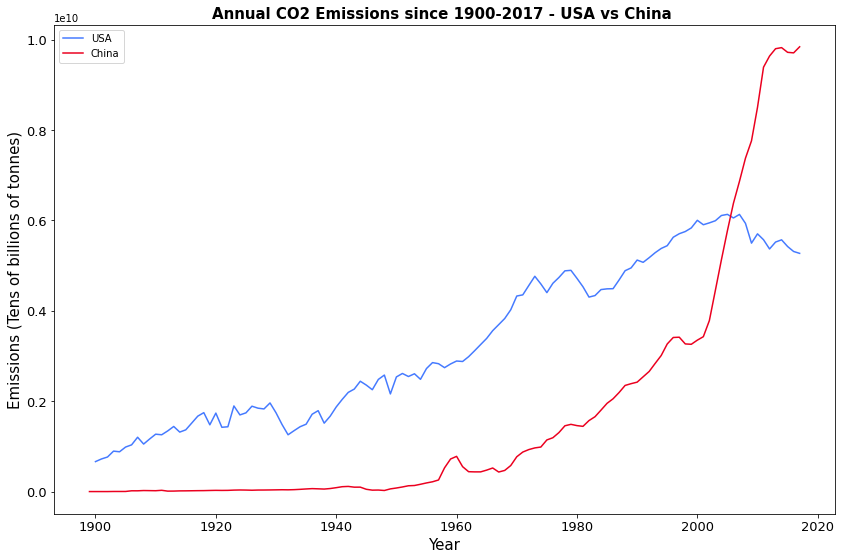

In [10]:
# Plot USA Data
plt.figure(figsize=(14,9))
plt.title('Annual CO2 Emissions since 1900-2017 - USA vs China ', fontdict={'fontsize':15, 'fontweight':'bold'})
x_axis = usa['Year']
x_2 = china["Year"]
plt.xlabel("Year", fontdict={'fontsize':15})
plt.ylabel("Emissions (Tens of billions of tonnes)", fontdict={'fontsize':15})
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.plot(x_axis, usa['Annual Emissions'], color='#457aff')
plt.plot(x_2, china['Annual Emissions'], color='#eb001f')
plt.legend(["USA", "China"])

plt.show()